# DSE-312: Computer Vision
# Assignment
- **Name:** Shraddha Agarwal
- **Roll No.:** 19294
- **Department:** Data Science and Engineering

In [3]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import os
import pandas as pd

# Session 1

## Ans 1: Pseudocode of SIFT Descriptor

Following steps are involved in the SIFT algorithm:-
1. Scale-space peak selection: Potential location for finding features.
2. Keypoint Localization: Accurately locating the feature keypoints.
3. Orientation Assignment: Assigning orientation to keypoints.
4. Keypoint descriptor: Describing the keypoints as a high dimensional vector.
5. Keypoint Matching
   
**Scale-Space peak Selction:**
      for an image IMG,
   - Produce Scale sapce of IMG by Convolution of Gaussian kernel(Blurring) at different scales with the input image.
   - Scale-space is separated into octaves and the number of octaves and scale depends on the size of the original image.
   - Within the Octave:
       for an image IMG:
          * images are progressively blurred using the Gaussian Blur operator.
          * Compute DoG of Each Image.
   - Calculate Laplacian of Gaussian approximations.

**KeyPoint Localization:**
   - For low contrast features, check their intensities.
   - If the intensity at this extrema is less than a threshold value (0.03 as
    per the paper), it is rejected
   - DoG has a higher response for edges, so edges should not be removed.
   - From Hessiam matrix H
   - Compute Principal Curvature Using Hessian Matrix.

**Orientation Assignment:**
(to assign an orientation to each keypoint to make it rotation invariance)
   - Take neighborhood around the keypoint location depending upon the scale
   - Calculate Gradient magnitute and Direction in that neighborhood.
   - Create orientation histogram with 36 bins covering 360 degress.
   - Take highest peak in the histogram i.e above 80% and calculate the
    orientation(keypoints with same location and scale, but of different
    directions is created)

**Keypoint descriptor:**
   - Take 16x16 window around the keypoint. Divide it into 16 sub_blocks of 4x4 size.
   - For each sub_block, create 8 bin orientation histogram
   - Rotate the image
   - Subtract the keypoint Orientation from each orientation.
   - Threshold the Number that are big to achieve the illumination
    independence.
   - Normalize the feature Vector.
   
**Keypoint Matching:**
   - Identify the nearest neighbors between two images and match them.
   - For case:
       * if second closest match is very near to the first:
        - calculate ratio of closest-distance to second-closest distance
        - if ratio > 0.8:
             * reject the images

**Uses of SIFT Descriptor:**
- The SIFT descriptor with its associated matching methods can be used for establishing point matches between different views of a 3-D object or a scene.
- SIFT can robustly identify objects even among clutter and under partial occlusion, because the SIFT feature descriptor is invariant to uniform scaling, orientation, illumination changes, and partially invariant to affine distortion.

**Applications of SIFT Descriptor:**
1. Object recognition using SIFT features
2. Robot localization and mapping
3. Panorama stitching
4. 3D scene modeling, recognition and tracking
5. 3D SIFT-like descriptors for human action recognition
6. Analyzing the Human Brain in 3D Magnetic Resonance Images

## Ans 2:    Viola-Jones Algorithm

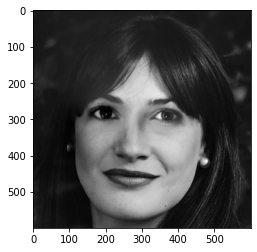

In [2]:
# loading the image
image = cv2.imread("archive\\real_and_fake_face\\training_fake\\easy_5_1100.jpg")

# Converting image to grayscale
img = cv2.cvtColor(image,cv2.COLOR_RGB2GRAY)

# visualizing the image
plt.imshow(img, 'gray')

In [3]:
# Loading the required haar-cascade xml classifier file
face_cascade = cv2.CascadeClassifier('haarcascade_frontalface_alt.xml')

# Applying the face detection method on the grayscale image
detected_faces = face_cascade.detectMultiScale(img)

In [4]:
# Iterating through rectangles of detected faces
for (column, row, width, height) in detected_faces:
    cv2.rectangle(image,
                 (column, row),
                 (column + width, row + height),
                 (0, 255, 0), 5)

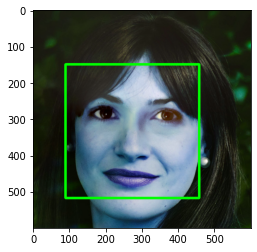

In [5]:
# Detection of the face
plt.imshow(image, 'gray')

### Steps of Viola-Jones Algorithm
• Scaling:
- Scale the detector (rather than the images)
- Features can easily be evaluated at any scale
- Scale by factors of 1.25

• Location:
- Move detector around the image (e.g., 1 pixel increments)

• Final Detections
- A real face may result in multiple nearby detections
- Post-process detected sub-windows to combine overlapping detections into a single detection

## Ans 3: Separating Objects using Clustering

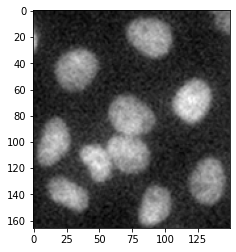

In [6]:
# loading the image
original_image = cv2.imread("tounching_grayscale.png")

# Converting image to grayscale
img = cv2.cvtColor(original_image,cv2.COLOR_BGR2GRAY)

# visualizing the image
plt.imshow(img, 'gray')

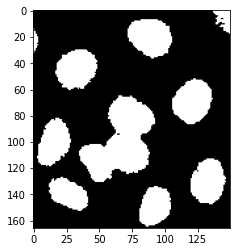

In [7]:
# convertig the image into binary image
ret, thresh = cv2.threshold(img,0,255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
plt.imshow(thresh, cmap = 'gray')

In [8]:
# noise removal using morphology
kernel = np.ones((3,3),np.uint8)
opening = cv2.morphologyEx(thresh,cv2.MORPH_OPEN, kernel, iterations = 2)

In [9]:
# sure background area
sure_bg = cv2.dilate(opening, kernel, iterations=5)

# Finding sure foreground area
dist_transform = cv2.distanceTransform(opening, cv2.DIST_L2, 5)
ret, sure_fg = cv2.threshold(dist_transform, 0.7*dist_transform.max(), 255, 0)

# Finding unknown region
sure_fg = np.uint8(sure_fg)
unknown = cv2.subtract(sure_bg, sure_fg)

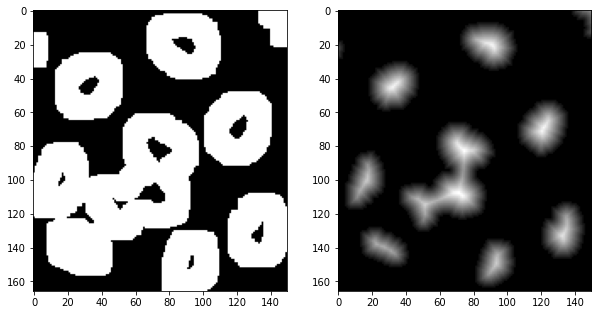

In [10]:
plt.figure(figsize=(10, 10))

# visualizing the unknown region
plt.subplot(121)
plt.imshow(unknown, cmap = 'gray')

# visualizing the transformed image
plt.subplot(122)
plt.imshow(dist_transform, cmap = 'gray')

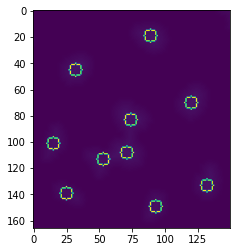

In [11]:
# forming separate clusters from the touching objects
from sklearn.cluster import KMeans
from skimage.feature import peak_local_max
local_max_location = peak_local_max(dist_transform, min_distance=1)
kmeans = KMeans(n_clusters=10)
kmeans.fit(local_max_location)
local_max_location = kmeans.cluster_centers_.copy()
local_max_location = local_max_location.astype(int)
local_max_location.shape
dist_transform_copy = dist_transform.copy()
for i in range(local_max_location.shape[0]):
    cv2.circle( dist_transform_copy, (local_max_location[i][1],local_max_location[i][0]), 5, 255)
    
# visualizing the clusters
plt.imshow(dist_transform_copy)

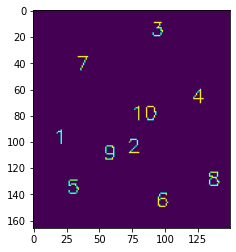

In [12]:
# counting the number of clusters
markers = np.zeros_like(dist_transform)
labels = np.arange(kmeans.n_clusters)
markers[local_max_location[:,0],local_max_location[:,1]] = labels + 1
markers = markers.astype(int)
markers_copy = markers.copy()
index_non_zero_markers = np.argwhere(markers != 0)
markers_copy = markers_copy.astype(np.uint8)
index_non_zero_markers
font = cv2.FONT_HERSHEY_SIMPLEX
for i in range(index_non_zero_markers.shape[0]):
    string_text = str(markers[index_non_zero_markers[i][0] ,index_non_zero_markers[i][1] ])
    cv2.putText( markers_copy, string_text, (index_non_zero_markers[i][1], index_non_zero_markers[i][0]), font, 0.5, 255)
plt.imshow(markers_copy)

**The touching objects are separated and there are 10 clusters obtained.**

## Ans 4: Eccentricity and Bounding Box

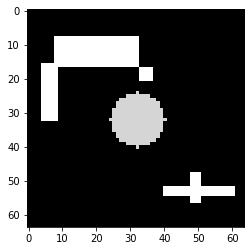

In [13]:
# loading the image
original_image = cv2.imread("shapes.png")

# making the copy of the original image
image = original_image.copy()

# Converting image to grayscale
img = cv2.cvtColor(original_image,cv2.COLOR_BGR2GRAY)

# visualizing the image
plt.imshow(img, 'gray')

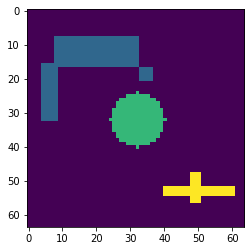

In [14]:
# marking the regions in the given image
from skimage.measure import label, regionprops, regionprops_table
label_im = label(img)
regions = regionprops(label_im)
plt.imshow(label_im)

In [15]:
# obtaining the values of eccentricity and bounding box of each shape
pd.DataFrame(regionprops_table(label_im, img, properties = ['eccentricity', 'bbox']))

eccentricity  bbox-0  bbox-1  bbox-2  bbox-3
0      0.866945       8       4      33      37
1      0.000000      24      24      41      41
2      0.948645      48      40      57      61

In [16]:
from skimage.measure import find_contours
from skimage.io import imread
import matplotlib.pyplot as plt
from skimage.color import rgb2gray

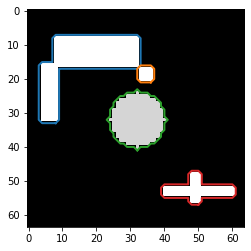

In [17]:
# visualizing the countours
contours = find_contours(img, 0.8)

fig, ax = plt.subplots()
ax.imshow(img, interpolation='nearest', cmap=plt.cm.gray)

for n, contour in enumerate(contours):
    ax.plot(contours[n][:, 1], contours[n][:, 0], linewidth=2)

plt.show()

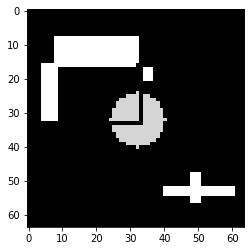

In [18]:
from skimage.draw import polygon_perimeter

bounding_boxes = []

for contour in contours:
    Xmin = np.min(contour[:,0])
    Xmax = np.max(contour[:,0])
    Ymin = np.min(contour[:,1])
    Ymax = np.max(contour[:,1])
    
    bounding_boxes.append([Xmin, Xmax, Ymin, Ymax])


with_boxes  = np.copy(img)

for box in bounding_boxes:
    
    r = [box[0],box[1],box[1],box[0], box[0]]
    c = [box[3],box[3],box[2],box[2], box[3]]
    rr, cc = polygon_perimeter(r, c, with_boxes.shape)
    with_boxes[rr, cc] = 1                                     #set color white

plt.imshow(with_boxes, interpolation='nearest', cmap=plt.cm.gray)
plt.show()

In [19]:
import matplotlib.patches as mpatches
from skimage.filters import threshold_otsu
from skimage.segmentation import clear_border
from skimage.measure import label, regionprops
from skimage.morphology import closing, square
from skimage.color import label2rgb

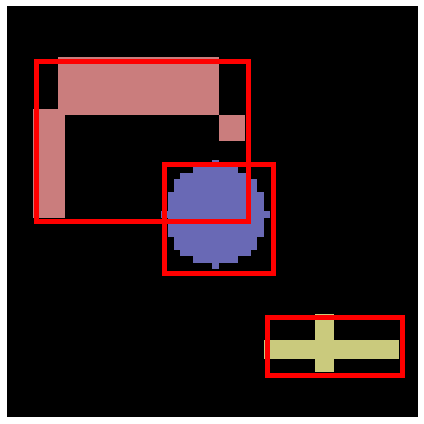

In [20]:
# label image regions
label_image = label(img)

# to make the background transparent, pass the value of `bg_label` and leave `bg_color` as `None` and `kind` as `overlay`
image_label_overlay = label2rgb(label_image, image=img, bg_label=0)

fig, ax = plt.subplots(figsize=(10, 6))
ax.imshow(image_label_overlay)

for region in regionprops(label_image):
    # take regions with large enough areas
    if region.area >= 50:
        # draw rectangle around segmented coins
        minr, minc, maxr, maxc = region.bbox
        rect = mpatches.Rectangle((minc, minr), maxc - minc, maxr - minr,
                                  fill=False, edgecolor='red', linewidth=5)
        ax.add_patch(rect)

ax.set_axis_off()
plt.tight_layout()
plt.show()

**Bounding Box around every object is shown in the above image.**

## Ans 5: Local Feature Matching

### Process of Harris Corner Detection Algorithm
1. Take the grayscale of the original image
2. Apply a Gaussian filter to smooth out any noise
3. Apply Sobel operator to find the x and y gradient values for every pixel in the grayscale image
4. For each pixel p in the grayscale image, consider a 3×3 window around it and compute the corner strength function. Call this its Harris value.
5. Find all pixels that exceed a certain threshold and are the local maxima within a certain window (to prevent redundant dupes of features)
6. For each pixel that meets the criteria in 5, compute a feature descriptor.

### Process of ORB Descriptor
1. Run each test against all training patches.
2. Order the tests by their distance from a mean of 0.5, forming the vector T.
3. Greedy search:
    - Put the first test into the result vector R and remove it from T.
    - Take the next test from T, and compare it against all tests in R. If its absolute correlation is greater than a threshold, discard it; else add it to R.
    - Repeat the previous step until there are 256 tests in R. If there are fewer than 256, raise the threshold and try again

In [124]:
# Loading the two different views of Monument image
image_view1 = cv2.imread('Monument_View1.jpg')
image_view2 = cv2.imread('Monument_View2.jpg')

# Converting the images into grayscale images
gray_1 = cv2.cvtColor(image_view1, cv2.COLOR_BGR2GRAY)
gray_1 = np.float32(gray_1)
gray_2 = cv2.cvtColor(image_view2, cv2.COLOR_BGR2GRAY)
gray_2 = np.float32(gray_2)

In [125]:
# Harris Corner Detection Method
corner_1 = cv2.cornerHarris(gray_1, 2, 5, 0.07)

# Result is dilated for marking the corners
corner_1 = cv2.dilate(corner_1, None)

har_view1 = cv2.imread('Monument_View1.jpg')
# Threshold for an optimal value
har_view1[corner_1 > 0.01 * corner_1.max()] = [0, 0, 255]

In [126]:
gray_1 = gray_1.astype(np.uint8)

# Initiate ORB detector
orb = cv2.ORB_create()

# finding the keypoints and descriptors with ORB
keypoints_orb_1, descriptors_1 = orb.detectAndCompute(gray_1, None)
orb_view1 = cv2.drawKeypoints(gray_1, keypoints_orb_1, None)

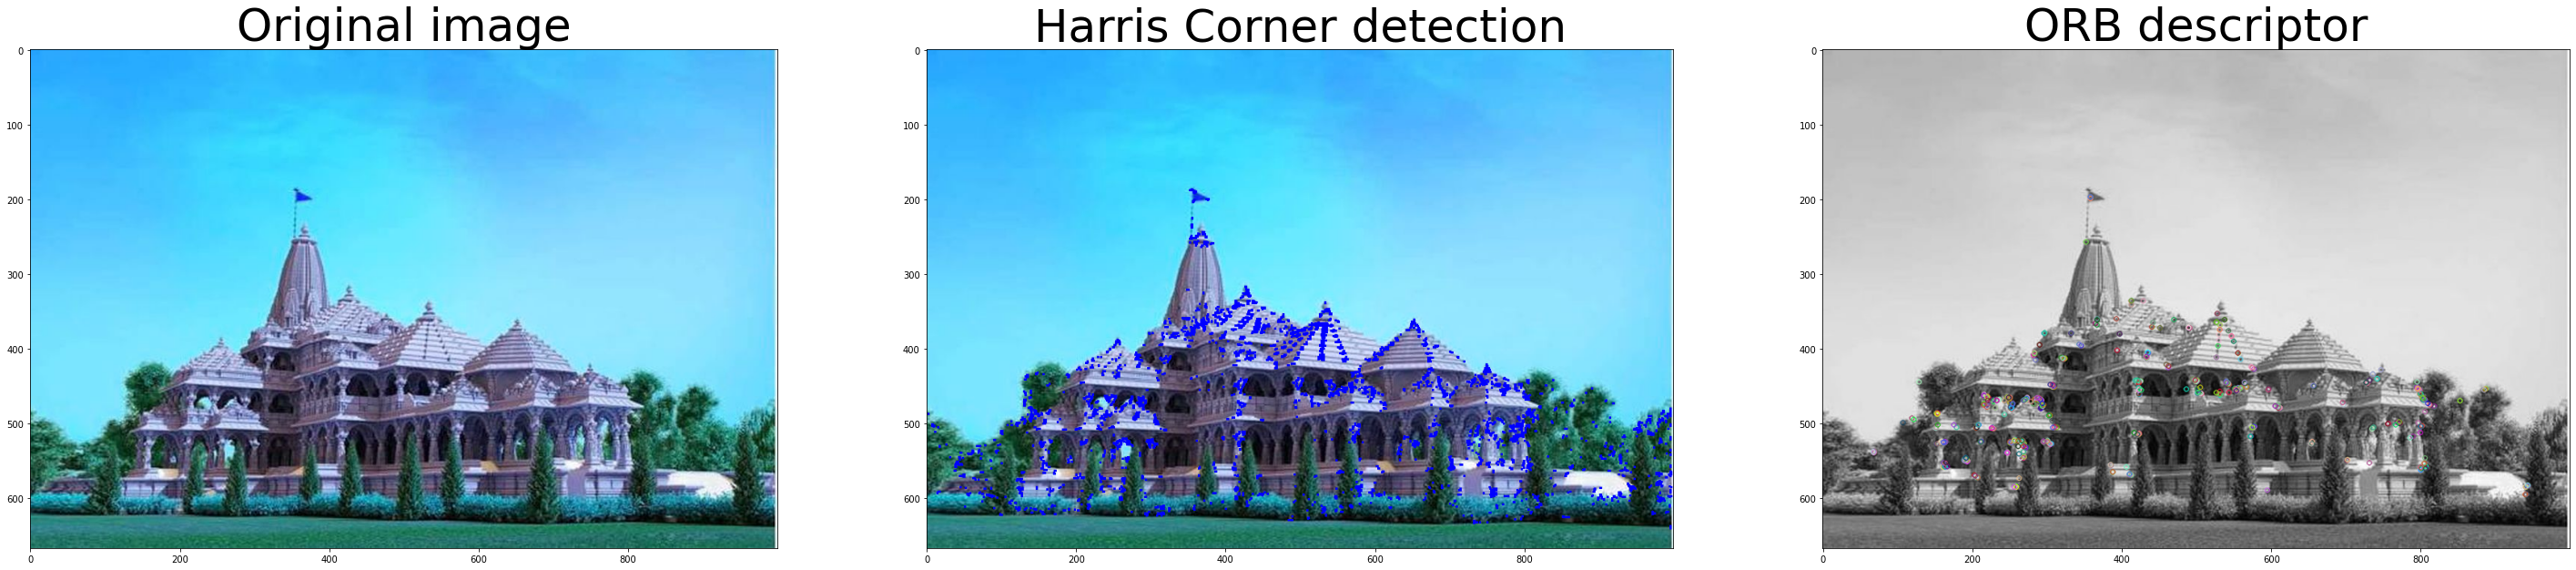

In [131]:
# Visualization of 1st view of monument image
plt.figure(figsize = (50, 50))

# Plotting the original image
plt.subplot(1,3,1)
plt.imshow(image_view1)
plt.title('Original image', fontsize = 50)

# Plotting the Harris Corner detected image
plt.subplot(1,3,2)
plt.imshow(har_view1)
plt.title('Harris Corner detection', fontsize = 50)

# Plotting the ORB descriptor
plt.subplot(1,3,3)
plt.imshow(orb_view1)
plt.title('ORB descriptor', fontsize = 50)
plt.show()

In [128]:
# Harris Corner Detection Method
corner_2 = cv2.cornerHarris(gray_2, 2, 5, 0.07)

# Result is dilated for marking the corners
corner_2 = cv2.dilate(corner_2, None)

har_view2 = cv2.imread('Monument_View2.jpg')
# Threshold for an optimal value
har_view2[corner_2 > 0.01 * corner_2.max()]=[0, 0, 255]

In [129]:
gray_2 = gray_2.astype(np.uint8)

# Initiate ORB detector
orb = cv2.ORB_create(nfeatures=1500)

# find the keypoints and descriptors with ORB
keypoints_orb_2, descriptors_2 = orb.detectAndCompute(gray_2, None)
orb_view2 = cv2.drawKeypoints(gray_2, keypoints_orb_2, None)

Text(0.5, 1.0, 'ORB descriptor')

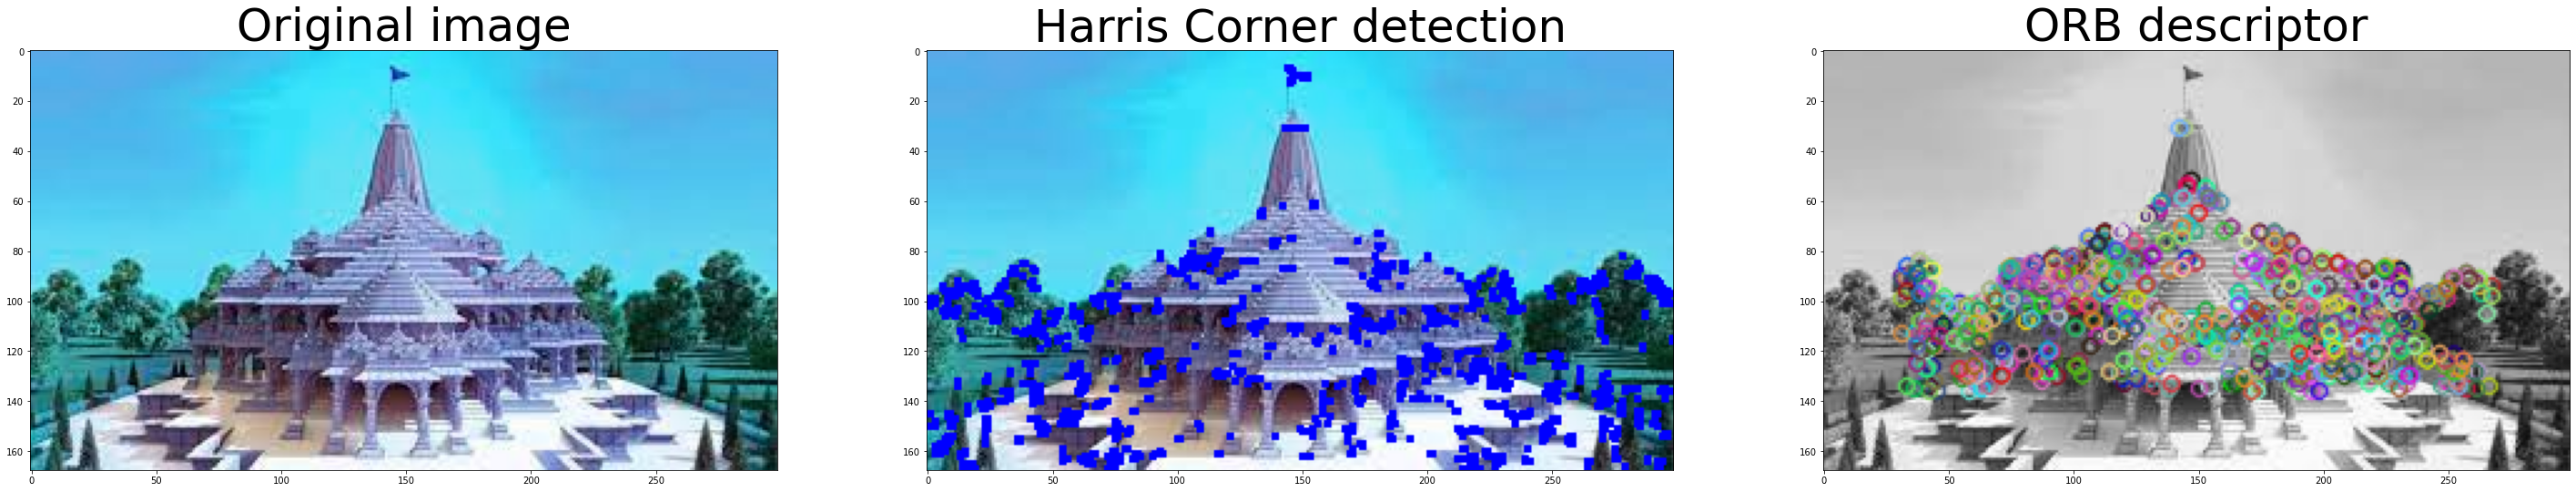

In [132]:
# Visualization of 2nd view of monument image
plt.figure(figsize = (50, 50))

# Plotting the original image
plt.subplot(1,3,1)
plt.imshow(image_view2)
plt.title('Original image', fontsize = 50)

# Plotting the Harris Corner detected image
plt.subplot(1,3,2)
plt.imshow(har_view2)
plt.title('Harris Corner detection', fontsize = 50)

# Plotting the ORB descriptor
plt.subplot(1,3,3)
plt.imshow(orb_view2)
plt.title('ORB descriptor', fontsize = 50)

In [133]:
desc1 = np.float32(descriptors_1)
desc2 = np.float32(descriptors_2)

In [134]:
# Implementing FLANN feature matching
FLANN_INDEX_KDTREE = 0
index_params = dict(algorithm = FLANN_INDEX_KDTREE, trees = 5)
search_params = dict(checks = 50)
flann = cv2.FlannBasedMatcher(index_params, search_params)
matches = flann.knnMatch(desc1, desc2, k=2)

In [135]:
good = []
for m, n in matches:
    if m.distance < 2*n.distance:
        good.append(m)

In [136]:
from skimage.measure import ransac, LineModelND
from skimage.transform import ProjectiveTransform, AffineTransform

# Choosing the source and destination points
src_pts = np.float32([keypoints_orb_1[m.queryIdx].pt for m in good ]).reshape(-1, 2)
dst_pts = np.float32([keypoints_orb_2[m.trainIdx].pt for m in good ]).reshape(-1, 2)

# Applying Ransac Algorithm
model, inliers = ransac(
            (src_pts, dst_pts),
            AffineTransform, min_samples=5,
            residual_threshold=8, max_trials=10000
        )

n_inliers = np.sum(inliers)

# Computing the homography on both images using chosen set of points
inlier_keypoints_left = [cv2.KeyPoint(point[0], point[1], 1) for point in src_pts[inliers]]
inlier_keypoints_right = [cv2.KeyPoint(point[0], point[1], 1) for point in dst_pts[inliers]]
placeholder_matches = [cv2.DMatch(idx, idx, 1) for idx in range(n_inliers)]
image3 = cv2.drawMatches(gray_1, inlier_keypoints_left, gray_2, inlier_keypoints_right, placeholder_matches, None)

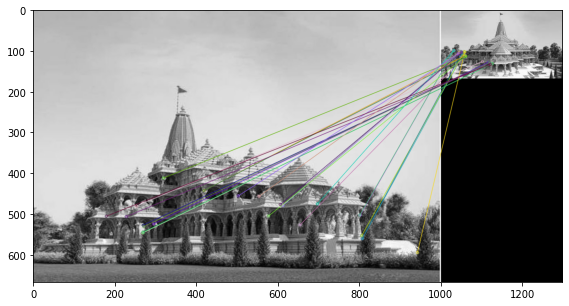

In [137]:
# Visualization of the resulting image after applying homography
plt.figure(figsize = (20,5))
plt.imshow(image3)

**Observation regarding keypoint descriptors:-**
- All repetitive structures have the same keypont descriptors and they uniquely identify that area.
- These are usually scale and rotation invariant.
- As these are scale and rotation invariant, keypoint descriptors are useful in finding similarities between to images,
  stitching two images having a common segment (e.g. making panorma)

## Ans 6: Binary Classification (Face vs Non-Face)

(600, 600, 3)


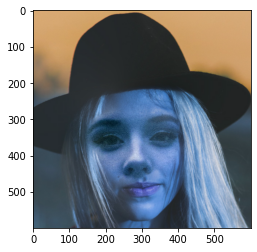

In [29]:
# loading and visualizing an image from the real and fake face images
image = cv2.imread("archive\\real_and_fake_face\\training_fake\\easy_12_1110.jpg")
plt.imshow(image)
print(image.shape)

In [148]:
from skimage.transform import resize
from skimage.feature import hog
from skimage import exposure

(512, 512, 3)


C:\Users\SHRADDHA\AppData\Local\Temp/ipykernel_46572/328160552.py:4: FutureWarning: `multichannel` is a deprecated argument name for `hog`. It will be removed in version 1.0. Please use `channel_axis` instead.
  fd, hog_image = hog(resized_img, orientations=9, pixels_per_cell=(32, 32),


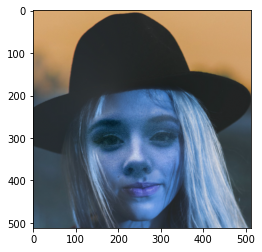

In [35]:
# applying HoG descriptor over the image
resized_img = resize(image, (512,512)) 
plt.imshow(resized_img) 
print(resized_img.shape)
fd, hog_image = hog(resized_img, orientations=9, pixels_per_cell=(32, 32), 
                cells_per_block=(2, 2), visualize=True, multichannel=True)

In [36]:
import os
list_of_training_images_fake = os.listdir("archive\\real_and_fake_face\\training_fake\\")
len(list_of_training_images_fake)

960

In [37]:
# Applying HoG transform and extracting the features of the training fake images
df_fake = pd.DataFrame()
j = 0
for i in list_of_training_images_fake:
    img = imread("archive\\real_and_fake_face\\training_fake\\"+i)
    resized_img = resize(img, (512,512))
    fd_fake, hog_image = hog(resized_img, orientations=9, pixels_per_cell=(32, 32), 
                    cells_per_block=(2, 2), visualize=True, multichannel=True)
    j = j+1
    print(fd_fake, len(fd_fake), " ", j)
    fds_fake = pd.Series(fd_fake)
    df_fake = df_fake.append(fds_fake,ignore_index=True)

C:\Users\SHRADDHA\AppData\Local\Temp/ipykernel_46572/526714694.py:6: FutureWarning: `multichannel` is a deprecated argument name for `hog`. It will be removed in version 1.0. Please use `channel_axis` instead.
  fd_fake, hog_image = hog(resized_img, orientations=9, pixels_per_cell=(32, 32),


[0.2306518  0.14188074 0.0763801  ... 0.07210345 0.09160626 0.16128694] 8100   1
[0.20694228 0.0059885  0.         ... 0.01823903 0.00145217 0.        ] 8100   2
[0.22092096 0.13597902 0.08926472 ... 0.27610605 0.27610605 0.27610605] 8100   3
[0.11785232 0.08853697 0.13941644 ... 0.24524697 0.24524697 0.2156214 ] 8100   4
[0.         0.         0.         ... 0.05397069 0.07464468 0.36858908] 8100   5
[0.23150692 0.12234755 0.09948248 ... 0.09446361 0.25225032 0.25225032] 8100   6
[0.08804443 0.04114066 0.04390315 ... 0.1711653  0.18963045 0.20976421] 8100   7
[0.33229847 0.07706131 0.01925855 ... 0.28456747 0.27312261 0.0594108 ] 8100   8
[0.04061231 0.0492671  0.08320507 ... 0.02338148 0.0474112  0.05525334] 8100   9
[0.11522753 0.13614504 0.1376321  ... 0.16550858 0.1285397  0.08976544] 8100   10
[0.15636153 0.13107385 0.23085173 ... 0.07160056 0.04418923 0.05102869] 8100   11
[0. 0. 0. ... 0. 0. 0.] 8100   12
[0.23380085 0.09882172 0.0727772  ... 0.03508091 0.33423321 0.33423321] 8

[0.12453769 0.07210875 0.0658155  ... 0.1003441  0.09013346 0.19183869] 8100   102
[0.06394407 0.04789524 0.0541342  ... 0.2540459  0.03672011 0.01045632] 8100   103
[0.00856691 0.01778768 0.04162963 ... 0.0901442  0.12339787 0.14780869] 8100   104
[0.1035103  0.02515576 0.03125671 ... 0.20635558 0.21426052 0.15659374] 8100   105
[0.18969091 0.15210382 0.11341282 ... 0.09331848 0.09214423 0.1080812 ] 8100   106
[0.05311785 0.03782056 0.05971043 ... 0.11027133 0.152697   0.16346323] 8100   107
[0.         0.         0.         ... 0.18962014 0.17604118 0.173989  ] 8100   108
[0.21147899 0.14387642 0.15169443 ... 0.14616521 0.1964682  0.18988021] 8100   109
[0.16377577 0.14905802 0.15117443 ... 0.14494986 0.12822102 0.11109173] 8100   110
[0.24718023 0.24631515 0.17601094 ... 0.14050986 0.12565825 0.09138723] 8100   111
[0.18329701 0.17994382 0.24636806 ... 0.13135197 0.12851835 0.1500706 ] 8100   112
[0.27736311 0.19539223 0.11950066 ... 0.0121986  0.00849489 0.00892613] 8100   113
[0.2

[0.18642695 0.08899188 0.08937956 ... 0.24141923 0.30219356 0.30219356] 8100   201
[0.10058221 0.04095926 0.07580158 ... 0.05541017 0.02477717 0.02005707] 8100   202
[0.0746178  0.11229714 0.28204801 ... 0.16610951 0.21783331 0.1411152 ] 8100   203
[0.10086198 0.10112192 0.09358988 ... 0.04957496 0.05359818 0.07901791] 8100   204
[0.30495766 0.15256342 0.27972791 ... 0.041097   0.06107599 0.04485067] 8100   205
[0.17813157 0.101868   0.11503827 ... 0.18047579 0.16645612 0.12225439] 8100   206
[0.17579553 0.08188251 0.03259028 ... 0.16081527 0.22676607 0.22676607] 8100   207
[0.18451859 0.07806585 0.12093771 ... 0.01472638 0.02140769 0.05170585] 8100   208
[0.17385616 0.15334422 0.17940753 ... 0.09270583 0.12132309 0.23437948] 8100   209
[0.15125974 0.15851499 0.18880477 ... 0.05260614 0.1378715  0.29289539] 8100   210
[0.25075849 0.25075849 0.15992843 ... 0.14178915 0.20528038 0.17953334] 8100   211
[0.05589988 0.05747551 0.10586164 ... 0.20116557 0.19248009 0.20034264] 8100   212
[0.2

[0.07543974 0.05272405 0.14027253 ... 0.1514464  0.08134517 0.09729537] 8100   300
[0.28696822 0.12323549 0.07461015 ... 0.08613412 0.16466007 0.24156505] 8100   301
[0.12875373 0.12136836 0.13346856 ... 0.11050467 0.06723169 0.05803313] 8100   302
[0.2408053  0.19182825 0.17697502 ... 0.09240046 0.23295172 0.29320242] 8100   303
[0.18747796 0.15850638 0.16339196 ... 0.19598009 0.17603086 0.22962991] 8100   304
[0.24937931 0.16219519 0.13313228 ... 0.14799787 0.11659014 0.17524156] 8100   305
[0.10078695 0.07184867 0.15059308 ... 0.01386204 0.00803395 0.00727926] 8100   306
[0.20988211 0.21604633 0.21334399 ... 0.09904437 0.1848696  0.23834597] 8100   307
[0.18803059 0.14736026 0.11643255 ... 0.33934221 0.06706049 0.03868036] 8100   308
[0.06376399 0.00121587 0.         ... 0.05027327 0.12296004 0.29989361] 8100   309
[0.22507686 0.19345185 0.08907872 ... 0.11146744 0.11048732 0.13979136] 8100   310
[0.24778211 0.08544531 0.06606408 ... 0.23951454 0.23951454 0.20429155] 8100   311
[0.2

[0.03689253 0.01036951 0.09498376 ... 0.01500206 0.01826312 0.0318948 ] 8100   398
[0.01430722 0.01416447 0.03225238 ... 0.17322969 0.30471548 0.30471548] 8100   399
[0.17708346 0.04973676 0.07505559 ... 0.08281618 0.03018879 0.05082501] 8100   400
[0.28158901 0.25779369 0.12391026 ... 0.05111325 0.09346444 0.12375944] 8100   401
[0.         0.         0.         ... 0.14373503 0.03102886 0.01700298] 8100   402
[0.21059847 0.13276644 0.13243384 ... 0.11224735 0.3584407  0.3584407 ] 8100   403
[0.02214915 0.04751621 0.19923955 ... 0.10124117 0.02450753 0.02581936] 8100   404
[0.22402447 0.16586224 0.17575554 ... 0.215423   0.18239377 0.18676486] 8100   405
[0.26352806 0.1829557  0.14112198 ... 0.21387132 0.12998379 0.13938745] 8100   406
[0.05997096 0.02855066 0.06988562 ... 0.2502205  0.17751471 0.25214763] 8100   407
[0.15520226 0.12210921 0.11394184 ... 0.03517181 0.07851515 0.11440616] 8100   408
[0.020917   0.04417861 0.19954958 ... 0.20673425 0.11932629 0.04726093] 8100   409
[0.1

[0.3408383  0.04012681 0.01125427 ... 0.07227807 0.09182152 0.10951542] 8100   497
[0.21569739 0.10780448 0.06501968 ... 0.18845125 0.21983081 0.16347083] 8100   498
[0.17115131 0.0837546  0.09502719 ... 0.03612404 0.08180163 0.22691671] 8100   499
[0.1539827  0.14052231 0.14955075 ... 0.01950347 0.05732993 0.3119182 ] 8100   500
[0.18518391 0.18530475 0.17843076 ... 0.22300513 0.30724032 0.30724032] 8100   501
[0.2975421  0.2975421  0.2975421  ... 0.12058771 0.25618529 0.25618529] 8100   502
[0.14007631 0.1522844  0.11975978 ... 0.06605988 0.04104748 0.03656324] 8100   503
[0.13525976 0.16534134 0.21013337 ... 0.10534962 0.08717517 0.04480412] 8100   504
[0.18580634 0.13000133 0.13481924 ... 0.15438648 0.25716627 0.25716627] 8100   505
[0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 4.37804246e-16
 1.75990353e-17 0.00000000e+00] 8100   506
[0.21298548 0.19259635 0.21298548 ... 0.03558443 0.04620884 0.12357606] 8100   507
[0.2003591  0.16714517 0.15542324 ... 0.4580275  0.05799941 0.

[0.18178926 0.23515611 0.2500597  ... 0.25168498 0.25349038 0.25349038] 8100   596
[0.09285149 0.09546149 0.08553453 ... 0.05730182 0.05883528 0.1585227 ] 8100   597
[0.21244524 0.19967343 0.17361259 ... 0.06445258 0.20550921 0.31601648] 8100   598
[0.19479453 0.15665551 0.16981035 ... 0.2102864  0.2102864  0.20791979] 8100   599
[5.97587128e-02 8.93371895e-16 1.25434095e-14 ... 6.22770176e-02
 6.75850697e-02 7.65980995e-02] 8100   600
[0.09493288 0.14611229 0.28510909 ... 0.15372763 0.15152994 0.15601497] 8100   601
[0.40668134 0.06343557 0.01362635 ... 0.27505891 0.27505891 0.11295096] 8100   602
[0.22052154 0.22052154 0.22052154 ... 0.0986491  0.09552468 0.09310777] 8100   603
[3.27720094e-01 1.79165806e-02 8.14255121e-14 ... 2.94744747e-02
 5.19561205e-02 1.18248835e-01] 8100   604
[0.22386826 0.12870884 0.11909275 ... 0.07574099 0.15724698 0.22606475] 8100   605
[0.15688671 0.14218006 0.16908963 ... 0.27273699 0.27273699 0.11529841] 8100   606
[0.07575788 0.06728045 0.03769362 ...

[0.21626019 0.21626019 0.21626019 ... 0.09003651 0.24365821 0.2948832 ] 8100   694
[0.07961828 0.05150793 0.03408106 ... 0.06196238 0.09821652 0.24089818] 8100   695
[0.22019441 0.22019441 0.22019441 ... 0.04196279 0.0349804  0.06522611] 8100   696
[0.29512424 0.19718202 0.29512424 ... 0.1133539  0.13445297 0.1948166 ] 8100   697
[0.22868057 0.21857599 0.1866218  ... 0.10987582 0.16008239 0.13116545] 8100   698
[0.17186613 0.19211345 0.10709171 ... 0.05041744 0.03526571 0.03125395] 8100   699
[0.22999785 0.11528853 0.0917881  ... 0.13094747 0.15558188 0.15188978] 8100   700
[0.09280908 0.03532681 0.02490356 ... 0.         0.         0.        ] 8100   701
[0.20133396 0.19170426 0.18426771 ... 0.0565763  0.09651192 0.12464527] 8100   702
[0.28191396 0.09661427 0.07626261 ... 0.37095991 0.31359253 0.08091558] 8100   703
[0.21190062 0.20261014 0.21190062 ... 0.17351453 0.21718613 0.16133812] 8100   704
[0.20265123 0.20265123 0.20265123 ... 0.19999705 0.16286387 0.16398302] 8100   705
[0.0

[0.08569953 0.06482941 0.04742342 ... 0.28587603 0.28587603 0.19010164] 8100   792
[0.14762856 0.13056654 0.18518275 ... 0.00704739 0.02425499 0.04712577] 8100   793
[0.27553956 0.06921906 0.09147254 ... 0.31999355 0.24415684 0.10315055] 8100   794
[0.17116175 0.14924018 0.13299317 ... 0.08565311 0.08221834 0.11362589] 8100   795
[0.02831163 0.05252809 0.09735757 ... 0.0868904  0.12343489 0.24971861] 8100   796
[0.27892282 0.20110631 0.13351891 ... 0.06326255 0.13229285 0.1297203 ] 8100   797
[0.15423086 0.20850265 0.21962118 ... 0.02880949 0.06150081 0.35636845] 8100   798
[0.1703341  0.10035799 0.10878426 ... 0.14362004 0.1738043  0.21705235] 8100   799
[0.05637554 0.01212474 0.01103231 ... 0.18429566 0.15211056 0.15462891] 8100   800
[0.23310969 0.23310969 0.23310969 ... 0.31642596 0.31642596 0.06832099] 8100   801
[0.18438041 0.13013545 0.10633172 ... 0.08141889 0.11123096 0.10595496] 8100   802
[0.20021499 0.13661446 0.13592984 ... 0.14598778 0.14052668 0.14169101] 8100   803
[0.1

[0.15507461 0.14734011 0.18567349 ... 0.27548477 0.27439552 0.17143821] 8100   891
[0.19680457 0.15286726 0.16333835 ... 0.32194752 0.32194752 0.04406753] 8100   892
[0.10001701 0.12363421 0.17362825 ... 0.10236594 0.15303183 0.12338899] 8100   893
[0.0668516  0.07822743 0.17610761 ... 0.43296748 0.05656002 0.01783484] 8100   894
[0.21194832 0.19710516 0.21194832 ... 0.06245645 0.07380034 0.32277683] 8100   895
[0.09743892 0.09430938 0.08058788 ... 0.11264573 0.14023625 0.13936894] 8100   896
[0.06671071 0.05393402 0.05348299 ... 0.09272814 0.07253567 0.06874346] 8100   897
[0.2972809  0.114944   0.07354541 ... 0.40833856 0.24690764 0.0427883 ] 8100   898
[0.23867912 0.23597283 0.15460064 ... 0.27642049 0.27642049 0.21595078] 8100   899
[0.22299314 0.19047373 0.16727763 ... 0.06950971 0.06883179 0.10109297] 8100   900
[0.20761817 0.14291948 0.14068669 ... 0.09002659 0.07399284 0.04330257] 8100   901
[0.03576564 0.01373986 0.0256932  ... 0.08262278 0.04387598 0.03363191] 8100   902
[0.1

In [38]:
# preparing the fake images dataset
df_fake

0         1         2         3         4         5         6     \
0    0.230652  0.141881  0.076380  0.077703  0.093578  0.129680  0.228946   
1    0.206942  0.005988  0.000000  0.001524  0.016285  0.012087  0.084780   
2    0.220921  0.135979  0.089265  0.107344  0.192139  0.140808  0.149828   
3    0.117852  0.088537  0.139416  0.132211  0.192544  0.049583  0.041581   
4    0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
..        ...       ...       ...       ...       ...       ...       ...   
955  0.197414  0.159516  0.169568  0.166451  0.197653  0.164442  0.160833   
956  0.180262  0.229648  0.229648  0.229648  0.196851  0.080102  0.069893   
957  0.201763  0.153613  0.175227  0.169771  0.171106  0.185646  0.160898   
958  0.218632  0.161152  0.124531  0.125373  0.176472  0.131256  0.217847   
959  0.190492  0.153349  0.150419  0.191998  0.206232  0.162154  0.206232   

         7         8         9     ...      8090      8091      8092  \
0    0.230652  0.230652  0.154647  ...  0.373495  0.190439  0.105238   
1    0.271736  0.351903  0.282223  ...  0.000213  0.008054  0.000000   
2    0.152157  0.201345  0.126733  ...  0.220032  0.159014  0.045525   
3    0.029319  0.059215  0.153898  ...  0.060270  0.144941  0.101507   
4    0.000000  0.000000  0.172559  ...  0.157433  0.368589  0.115908   
..        ...       ...       ...  ...       ...       ...       ...   
955  0.161003  0.159776  0.183949  ...  0.170697  0.198740  0.141719   
956  0.097163  0.116690  0.229648  ...  0.192121  0.133045  0.221212   
957  0.115232  0.148196  0.178840  ...  0.149683  0.157657  0.142994   
958  0.218632  0.218632  0.190126  ...  0.193921  0.163584  0.158905   
959  0.166520  0.130216  0.206232  ...  0.084055  0.063786  0.036666   

         8093      8094      8095      8096      8097      8098      8099  
0    0.068865  0.034508  0.045456  0.041418  0.072103  0.091606  0.161287  
1    0.023561  0.216234  0.366677  0.226074  0.018239  0.001452  0.000000  
2    0.024081  0.022767  0.043927  0.071572  0.276106  0.276106  0.276106  
3    0.062140  0.107346  0.180729  0.217395  0.245247  0.245247  0.215621  
4    0.055348  0.049637  0.243779  0.061343  0.053971  0.074645  0.368589  
..        ...       ...       ...       ...       ...       ...       ...  
955  0.156254  0.161054  0.195828  0.143908  0.163044  0.128318  0.180441  
956  0.221212  0.221212  0.172138  0.120683  0.118631  0.154342  0.102725  
957  0.133364  0.201159  0.175809  0.193266  0.170174  0.127015  0.132061  
958  0.202413  0.179285  0.146070  0.149133  0.172666  0.154214  0.120406  
959  0.031681  0.044609  0.106864  0.388676  0.441438  0.058005  0.048567  

[960 rows x 8100 columns]

In [39]:
list_of_training_images_real = os.listdir("archive\\real_and_fake_face\\training_real\\")
len(list_of_training_images_real)

1081

In [40]:
# Applying HoG transform and extracting the features of the training real images
df_real = pd.DataFrame()
j = 0
for i in list_of_training_images_real:
    img = imread("archive\\real_and_fake_face\\training_real\\"+i)
    resized_img = resize(img, (512,512))
    fd_real, hog_image = hog(resized_img, orientations=9, pixels_per_cell=(32, 32), 
                    cells_per_block=(2, 2), visualize=True, multichannel=True)
    j = j+1
    print(fd_real, len(fd_real), " ", j)
    fds_real = pd.Series(fd_real)
    df_real = df_real.append(fds_real,ignore_index=True)

C:\Users\SHRADDHA\AppData\Local\Temp/ipykernel_46572/3927942607.py:6: FutureWarning: `multichannel` is a deprecated argument name for `hog`. It will be removed in version 1.0. Please use `channel_axis` instead.
  fd_real, hog_image = hog(resized_img, orientations=9, pixels_per_cell=(32, 32),


[0.18636688 0.2852772  0.2852772  ... 0.19410722 0.14874346 0.13728834] 8100   1
[0.         0.         0.         ... 0.23712357 0.22451926 0.12622556] 8100   2
[0.19043286 0.15423272 0.14262753 ... 0.25147882 0.18069826 0.1418329 ] 8100   3
[0.08576781 0.22829741 0.27818166 ... 0.1666477  0.18770901 0.14639961] 8100   4
[0.18496385 0.17393826 0.1412881  ... 0.08872096 0.07469269 0.04571101] 8100   5
[0.16817896 0.15080557 0.16021547 ... 0.10104572 0.09112255 0.09687292] 8100   6
[0.27025322 0.27025322 0.14818267 ... 0.19748937 0.18031263 0.1981361 ] 8100   7
[0.20204268 0.15763916 0.16524622 ... 0.1775404  0.13446376 0.13953605] 8100   8
[0.39549467 0.61762845 0.61762845 ... 0.09093058 0.09991907 0.09814262] 8100   9
[0.0534523  0.04616991 0.04444624 ... 0.27510954 0.16859998 0.07912446] 8100   10
[0.113906   0.11080816 0.15047524 ... 0.14796917 0.15835657 0.1647506 ] 8100   11
[0.01535731 0.01630104 0.0517635  ... 0.13344023 0.03319534 0.04514177] 8100   12
[0.17980126 0.16109832 0.

[0.         0.         0.         ... 0.01983111 0.02732893 0.02683257] 8100   101
[0.03054992 0.02429116 0.01199722 ... 0.24660921 0.24660921 0.21313863] 8100   102
[0.38523603 0.38523603 0.04929228 ... 0.10319407 0.07056409 0.09023718] 8100   103
[0.08713449 0.04224625 0.02806352 ... 0.11904331 0.06663675 0.0600795 ] 8100   104
[0.26102239 0.26102239 0.26102239 ... 0.12234639 0.14932215 0.22831226] 8100   105
[0.29401126 0.29401126 0.23710262 ... 0.10460929 0.0676064  0.14418951] 8100   106
[0.15822527 0.1230756  0.19613151 ... 0.31573722 0.31573722 0.11934155] 8100   107
[0.00493925 0.00250866 0.00341707 ... 0.08777899 0.06808286 0.07081435] 8100   108
[0.28461257 0.16077185 0.02056426 ... 0.09692343 0.25439954 0.31066182] 8100   109
[0.1607332  0.11086568 0.2048862  ... 0.29327249 0.11088998 0.03586633] 8100   110
[0.16615737 0.10605508 0.10792811 ... 0.04383776 0.04804411 0.04892339] 8100   111
[0.27205891 0.08617373 0.08287601 ... 0.2022657  0.21556942 0.23571434] 8100   112
[0.0

[0.15110054 0.12173807 0.12990279 ... 0.10903501 0.1210698  0.12718605] 8100   200
[0.27555967 0.29778508 0.20337371 ... 0.05951838 0.05290277 0.06177121] 8100   201
[0.02044635 0.01421612 0.04639323 ... 0.28918915 0.28918915 0.15112607] 8100   202
[0.12388409 0.21036127 0.24023042 ... 0.16913528 0.26790638 0.26790638] 8100   203
[0.08239659 0.07981381 0.11541235 ... 0.12006012 0.12273541 0.09201765] 8100   204
[0.05237755 0.0323123  0.08032059 ... 0.26785935 0.07877527 0.03618125] 8100   205
[0.21507939 0.06528812 0.08568456 ... 0.21664211 0.21664211 0.21664211] 8100   206
[0.15306777 0.11399257 0.14975879 ... 0.0576125  0.13881013 0.27070316] 8100   207
[0.34374968 0.13544979 0.03280049 ... 0.09057366 0.1972772  0.30160769] 8100   208
[0.1361553  0.07207742 0.22758897 ... 0.1439412  0.12258609 0.21497068] 8100   209
[0.29356007 0.15043383 0.04599363 ... 0.26498007 0.21276772 0.07233754] 8100   210
[0.3167455  0.13183916 0.0831612  ... 0.06548257 0.03586729 0.01488683] 8100   211
[0.2

[0.04660043 0.08559366 0.15371302 ... 0.18215852 0.06365356 0.07407097] 8100   299
[0.26733662 0.26733662 0.13851699 ... 0.05276508 0.15888484 0.24154758] 8100   300
[0.13882425 0.11134251 0.13379514 ... 0.07031634 0.19207681 0.37004455] 8100   301
[0.17732344 0.16766085 0.13450634 ... 0.27644028 0.27644028 0.13756642] 8100   302
[0.22157516 0.22157516 0.20722724 ... 0.031581   0.16616718 0.34038657] 8100   303
[0.13348628 0.06533948 0.08931634 ... 0.11568406 0.28904489 0.28904489] 8100   304
[0.12637821 0.04721906 0.07228297 ... 0.03355507 0.10779231 0.25173384] 8100   305
[0.20064726 0.13376204 0.12102127 ... 0.14121771 0.25598021 0.24201895] 8100   306
[0.0307189  0.03278134 0.11112253 ... 0.11765584 0.12725351 0.19006848] 8100   307
[0.24203573 0.1519958  0.12923135 ... 0.16459558 0.31871046 0.31871046] 8100   308
[0.         0.         0.         ... 0.19869771 0.27262179 0.27262179] 8100   309
[0.22967133 0.18413309 0.18172666 ... 0.09132867 0.08771345 0.09529568] 8100   310
[0.1

[0.20270552 0.19045929 0.14324817 ... 0.17192829 0.15234831 0.17865971] 8100   399
[0.22676294 0.19075662 0.18872178 ... 0.15604321 0.1374231  0.18639214] 8100   400
[0.15201729 0.16280874 0.1629795  ... 0.14081984 0.14865494 0.19056205] 8100   401
[0.22278461 0.22278461 0.22278461 ... 0.17880575 0.30558861 0.30558861] 8100   402
[0.21371053 0.17396153 0.16039556 ... 0.20655834 0.06089899 0.05399449] 8100   403
[0.21847939 0.21847939 0.13387315 ... 0.17355816 0.17586357 0.15748463] 8100   404
[0.23696815 0.23696815 0.20251368 ... 0.06413835 0.13073587 0.2178038 ] 8100   405
[0.20073531 0.15168824 0.13556806 ... 0.14012397 0.18915068 0.2040528 ] 8100   406
[0.16934689 0.1377308  0.13495965 ... 0.21262204 0.09269248 0.05785938] 8100   407
[0.13395312 0.09012646 0.07879171 ... 0.15132437 0.35702267 0.19272928] 8100   408
[0.21748003 0.21748003 0.21728261 ... 0.19409683 0.17769562 0.11995063] 8100   409
[0.11928635 0.13963717 0.1520056  ... 0.1219942  0.12068495 0.09836458] 8100   410
[0.2

[0.30828168 0.30828168 0.10875971 ... 0.08479311 0.12279029 0.22314721] 8100   498
[0.21604003 0.21604003 0.21604003 ... 0.22624918 0.22624918 0.22624918] 8100   499
[0.0891689  0.08227756 0.14931986 ... 0.27145784 0.13667841 0.17743108] 8100   500
[0.10382318 0.05899708 0.17501201 ... 0.19570272 0.13922288 0.09425451] 8100   501
[0.16534412 0.16536894 0.23332912 ... 0.23964871 0.11483188 0.09449377] 8100   502
[0.19502908 0.17046556 0.1502379  ... 0.25003362 0.22593676 0.18926034] 8100   503
[0.07817004 0.05767541 0.11296171 ... 0.10952804 0.09567899 0.08607889] 8100   504
[0.21841404 0.21841404 0.14238893 ... 0.08640834 0.09735633 0.16757444] 8100   505
[0.21460978 0.16914896 0.20480612 ... 0.28484306 0.267724   0.07017149] 8100   506
[0.13613475 0.15373932 0.1597265  ... 0.06024809 0.06742761 0.07211147] 8100   507
[0.17853047 0.15230274 0.13292614 ... 0.09444114 0.17224033 0.27567022] 8100   508
[0.28047013 0.28047013 0.18731354 ... 0.04749994 0.02556781 0.03373687] 8100   509
[0.0

[0.63946927 0.05637941 0.03294422 ... 0.15224798 0.31927473 0.31927473] 8100   597
[0.07315554 0.08791063 0.17508748 ... 0.13804001 0.15516846 0.10874022] 8100   598
[0.13485594 0.16008656 0.15338337 ... 0.12010681 0.13656439 0.115929  ] 8100   599
[0.05039532 0.00519591 0.00846099 ... 0.3048911  0.3048911  0.19662513] 8100   600
[0.22533701 0.22533701 0.16877839 ... 0.24049558 0.17713234 0.16453746] 8100   601
[0.02377732 0.01552721 0.10388229 ... 0.07091009 0.07327928 0.10419352] 8100   602
[0.27583757 0.15968979 0.03766548 ... 0.05384283 0.11623993 0.07061363] 8100   603
[0.2545299  0.18533778 0.13892083 ... 0.16389428 0.06760364 0.02203973] 8100   604
[2.07082615e-07 7.27304913e-09 7.35981138e-08 ... 1.00801255e-01
 9.78015875e-02 1.16680121e-01] 8100   605
[0.07933047 0.03095963 0.01985139 ... 0.3147574  0.37029049 0.1435587 ] 8100   606
[0.09896856 0.08773652 0.11888264 ... 0.01023616 0.02182126 0.09426197] 8100   607
[0.05292404 0.06263128 0.1782392  ... 0.18148365 0.16637334 0.

[0.33359177 0.03624219 0.01167156 ... 0.07180683 0.11402724 0.12256389] 8100   696
[0.03581782 0.03565828 0.26438203 ... 0.00538356 0.00975417 0.03507063] 8100   697
[0.30319643 0.30319643 0.30319643 ... 0.06161505 0.06574289 0.09741151] 8100   698
[0.03622597 0.0176761  0.03177117 ... 0.16955606 0.06979632 0.10321875] 8100   699
[0.06436908 0.05239133 0.08830281 ... 0.27626152 0.27626152 0.27626152] 8100   700
[0.19344818 0.17384974 0.14427771 ... 0.18172199 0.10283606 0.06863007] 8100   701
[0.0913418  0.06443404 0.09505098 ... 0.23960827 0.36426507 0.06300407] 8100   702
[0.22164977 0.1500179  0.14467794 ... 0.10439834 0.06385699 0.04894908] 8100   703
[0.22668012 0.22668012 0.20392598 ... 0.25775714 0.1745529  0.04021453] 8100   704
[0.12251303 0.08601115 0.09715954 ... 0.30315218 0.30315218 0.06785399] 8100   705
[0.03718386 0.00872388 0.00398135 ... 0.01826698 0.03145889 0.18984995] 8100   706
[0.19638128 0.1292186  0.12240257 ... 0.07122981 0.05283492 0.12505386] 8100   707
[0.3

[0.41598571 0.01430973 0.01081372 ... 0.25201647 0.14469433 0.08619088] 8100   795
[0.18871449 0.13714766 0.09547832 ... 0.12924438 0.26191781 0.26191781] 8100   796
[0.03635497 0.02252169 0.04187778 ... 0.06445126 0.01781222 0.00709502] 8100   797
[0.17574812 0.10893683 0.16785484 ... 0.14504931 0.17963219 0.1221765 ] 8100   798
[0.16011288 0.12412666 0.08975074 ... 0.24053091 0.16907648 0.1131098 ] 8100   799
[0.23601723 0.08311535 0.06075737 ... 0.147119   0.10140865 0.07389385] 8100   800
[0.10331804 0.1237092  0.16317589 ... 0.28237929 0.02748537 0.01565962] 8100   801
[0.18500417 0.10564998 0.11493123 ... 0.10749794 0.17587627 0.28944865] 8100   802
[0.2521769  0.32563917 0.32563917 ... 0.10827867 0.13966964 0.26754477] 8100   803
[0.24014345 0.12091706 0.14607896 ... 0.29106309 0.27040533 0.1101746 ] 8100   804
[0.55413861 0.29163581 0.0633396  ... 0.07523662 0.15151632 0.22003455] 8100   805
[0.20548681 0.20548681 0.18126172 ... 0.06366103 0.04530056 0.04724383] 8100   806
[0.2

[0.1597595  0.23283594 0.17490405 ... 0.09310339 0.22655562 0.31012905] 8100   894
[0.17737391 0.0243452  0.01241368 ... 0.05641268 0.02221667 0.03053335] 8100   895
[0.21739224 0.21739224 0.21739224 ... 0.10916379 0.09478389 0.13105324] 8100   896
[0.2012396  0.15560379 0.2012396  ... 0.06472869 0.05936133 0.09903066] 8100   897
[0.21107918 0.18572797 0.17102553 ... 0.12704861 0.10050076 0.09434003] 8100   898
[0.25710274 0.25710274 0.23331696 ... 0.1086692  0.15925609 0.22484837] 8100   899
[0.09369489 0.04544493 0.05443669 ... 0.02705213 0.01426193 0.0172987 ] 8100   900
[0.21832457 0.18538072 0.10876069 ... 0.00496195 0.04624643 0.39805746] 8100   901
[0.28485189 0.2068707  0.09703978 ... 0.06015746 0.04665367 0.07548158] 8100   902
[0.29964128 0.20037371 0.09508241 ... 0.38527034 0.08459776 0.02136458] 8100   903
[0.24004046 0.17260234 0.09484457 ... 0.1506527  0.31977695 0.31977695] 8100   904
[0.28067604 0.11126825 0.08578422 ... 0.08653939 0.06860172 0.05553252] 8100   905
[0. 

[0.20243343 0.20243343 0.17170995 ... 0.15669006 0.15813266 0.15812674] 8100   993
[0.22135211 0.22135211 0.22135211 ... 0.06197543 0.12963857 0.21396233] 8100   994
[0.28246318 0.08457733 0.02991058 ... 0.28518823 0.28518823 0.11019476] 8100   995
[0.10154243 0.08219657 0.18738649 ... 0.01988022 0.01808612 0.02899918] 8100   996
[0.19560078 0.13850629 0.14769981 ... 0.16283348 0.12880689 0.10300389] 8100   997
[0.20865543 0.04388676 0.02222072 ... 0.14158909 0.10282107 0.07177572] 8100   998
[0.15402413 0.14299724 0.15823596 ... 0.13769435 0.15961281 0.15373656] 8100   999
[0.20621178 0.17191598 0.13643081 ... 0.24781774 0.09949473 0.03670218] 8100   1000
[0.11490042 0.09221791 0.13382239 ... 0.21125634 0.16775698 0.15091352] 8100   1001
[0.20813127 0.21722905 0.21330646 ... 0.25772631 0.2918847  0.27949682] 8100   1002
[0.22685545 0.22685545 0.14163054 ... 0.06855677 0.07599932 0.06610517] 8100   1003
[0.16176073 0.1332586  0.09276021 ... 0.07341699 0.16517644 0.31904797] 8100   1004

In [41]:
# preparing the real images dataset
df_real

0         1             2             3             4     \
0     1.863669e-01  0.285277  2.852772e-01  1.716521e-01  1.498003e-01   
1     0.000000e+00  0.000000  0.000000e+00  0.000000e+00  0.000000e+00   
2     1.904329e-01  0.154233  1.426275e-01  1.573469e-01  1.834742e-01   
3     8.576781e-02  0.228297  2.781817e-01  6.888594e-02  4.988356e-02   
4     1.849639e-01  0.173938  1.412881e-01  1.535252e-01  1.742698e-01   
...            ...       ...           ...           ...           ...   
1076  0.000000e+00  0.000000  0.000000e+00  0.000000e+00  0.000000e+00   
1077  1.105725e-01  0.043258  4.454689e-02  3.499102e-02  8.079261e-02   
1078  1.652840e-15  0.000000  4.781186e-16  2.099922e-17  1.812489e-15   
1079  1.547211e-01  0.140838  1.373285e-01  1.542302e-01  2.013386e-01   
1080  2.051370e-01  0.165663  1.916673e-01  1.773299e-01  2.051370e-01   

              5             6             7         8         9     ...  \
0     4.427886e-02  2.985140e-02  2.549894e-02  0.063519  0.135834  ...   
1     0.000000e+00  0.000000e+00  0.000000e+00  0.000000  0.000000  ...   
2     1.666708e-01  1.745083e-01  1.712223e-01  0.192224  0.194271  ...   
3     4.124591e-02  4.281152e-02  4.341578e-02  0.042916  0.096553  ...   
4     1.354031e-01  1.463914e-01  1.741495e-01  0.145237  0.229452  ...   
...            ...           ...           ...       ...       ...  ...   
1076  0.000000e+00  0.000000e+00  0.000000e+00  0.000000  0.000000  ...   
1077  3.728255e-02  2.766594e-02  4.740454e-02  0.065038  0.100011  ...   
1078  2.099922e-17  3.320267e-16  2.099922e-17  0.000000  0.002007  ...   
1079  1.908126e-01  1.748248e-01  1.794789e-01  0.166381  0.184428  ...   
1080  2.051370e-01  2.051370e-01  2.031810e-01  0.159532  0.160224  ...   

          8090      8091      8092      8093      8094      8095      8096  \
0     0.112157  0.172902  0.133295  0.155384  0.182538  0.203569  0.203569   
1     0.367447  0.102011  0.061087  0.076647  0.094941  0.207917  0.212307   
2     0.251869  0.132841  0.080870  0.096751  0.085403  0.184639  0.222511   
3     0.170184  0.186352  0.168322  0.162287  0.173298  0.158670  0.157489   
4     0.063092  0.071985  0.093046  0.205156  0.238315  0.238315  0.138964   
...        ...       ...       ...       ...       ...       ...       ...   
1076  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
1077  0.222684  0.222684  0.126568  0.087117  0.151982  0.222684  0.145090   
1078  0.010931  0.242323  0.187503  0.203520  0.149099  0.242323  0.242323   
1079  0.112967  0.286934  0.195634  0.109489  0.101433  0.099316  0.109236   
1080  0.157237  0.201795  0.168650  0.168179  0.165617  0.187600  0.158328   

          8097      8098      8099  
0     0.194107  0.148743  0.137288  
1     0.237124  0.224519  0.126226  
2     0.251479  0.180698  0.141833  
3     0.166648  0.187709  0.146400  
4     0.088721  0.074693  0.045711  
...        ...       ...       ...  
1076  0.000000  0.000000  0.000000  
1077  0.145254  0.132241  0.209362  
1078  0.231640  0.214104  0.219957  
1079  0.179667  0.286934  0.286934  
1080  0.187583  0.159857  0.168717  

[1081 rows x 8100 columns]

In [42]:
target_fake = [0 for i in range(len(list_of_training_images_fake))]
target_real = [1 for i in range(len(list_of_training_images_real))]
target_fake = pd.Series(target_fake)
target_real = pd.Series(target_real)

In [43]:
# Defining the target variable for the fake images dataset
df_fake["Target"] = target_fake
df_fake

0         1         2         3         4         5         6  \
0    0.230652  0.141881  0.076380  0.077703  0.093578  0.129680  0.228946   
1    0.206942  0.005988  0.000000  0.001524  0.016285  0.012087  0.084780   
2    0.220921  0.135979  0.089265  0.107344  0.192139  0.140808  0.149828   
3    0.117852  0.088537  0.139416  0.132211  0.192544  0.049583  0.041581   
4    0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
..        ...       ...       ...       ...       ...       ...       ...   
955  0.197414  0.159516  0.169568  0.166451  0.197653  0.164442  0.160833   
956  0.180262  0.229648  0.229648  0.229648  0.196851  0.080102  0.069893   
957  0.201763  0.153613  0.175227  0.169771  0.171106  0.185646  0.160898   
958  0.218632  0.161152  0.124531  0.125373  0.176472  0.131256  0.217847   
959  0.190492  0.153349  0.150419  0.191998  0.206232  0.162154  0.206232   

            7         8         9  ...      8091      8092      8093  \
0    0.230652  0.230652  0.154647  ...  0.190439  0.105238  0.068865   
1    0.271736  0.351903  0.282223  ...  0.008054  0.000000  0.023561   
2    0.152157  0.201345  0.126733  ...  0.159014  0.045525  0.024081   
3    0.029319  0.059215  0.153898  ...  0.144941  0.101507  0.062140   
4    0.000000  0.000000  0.172559  ...  0.368589  0.115908  0.055348   
..        ...       ...       ...  ...       ...       ...       ...   
955  0.161003  0.159776  0.183949  ...  0.198740  0.141719  0.156254   
956  0.097163  0.116690  0.229648  ...  0.133045  0.221212  0.221212   
957  0.115232  0.148196  0.178840  ...  0.157657  0.142994  0.133364   
958  0.218632  0.218632  0.190126  ...  0.163584  0.158905  0.202413   
959  0.166520  0.130216  0.206232  ...  0.063786  0.036666  0.031681   

         8094      8095      8096      8097      8098      8099  Target  
0    0.034508  0.045456  0.041418  0.072103  0.091606  0.161287       0  
1    0.216234  0.366677  0.226074  0.018239  0.001452  0.000000       0  
2    0.022767  0.043927  0.071572  0.276106  0.276106  0.276106       0  
3    0.107346  0.180729  0.217395  0.245247  0.245247  0.215621       0  
4    0.049637  0.243779  0.061343  0.053971  0.074645  0.368589       0  
..        ...       ...       ...       ...       ...       ...     ...  
955  0.161054  0.195828  0.143908  0.163044  0.128318  0.180441       0  
956  0.221212  0.172138  0.120683  0.118631  0.154342  0.102725       0  
957  0.201159  0.175809  0.193266  0.170174  0.127015  0.132061       0  
958  0.179285  0.146070  0.149133  0.172666  0.154214  0.120406       0  
959  0.044609  0.106864  0.388676  0.441438  0.058005  0.048567       0  

[960 rows x 8101 columns]

In [44]:
# Defining the target variable for the real images dataset
df_real["Target"] = target_real
df_real

0         1             2             3             4  \
0     1.863669e-01  0.285277  2.852772e-01  1.716521e-01  1.498003e-01   
1     0.000000e+00  0.000000  0.000000e+00  0.000000e+00  0.000000e+00   
2     1.904329e-01  0.154233  1.426275e-01  1.573469e-01  1.834742e-01   
3     8.576781e-02  0.228297  2.781817e-01  6.888594e-02  4.988356e-02   
4     1.849639e-01  0.173938  1.412881e-01  1.535252e-01  1.742698e-01   
...            ...       ...           ...           ...           ...   
1076  0.000000e+00  0.000000  0.000000e+00  0.000000e+00  0.000000e+00   
1077  1.105725e-01  0.043258  4.454689e-02  3.499102e-02  8.079261e-02   
1078  1.652840e-15  0.000000  4.781186e-16  2.099922e-17  1.812489e-15   
1079  1.547211e-01  0.140838  1.373285e-01  1.542302e-01  2.013386e-01   
1080  2.051370e-01  0.165663  1.916673e-01  1.773299e-01  2.051370e-01   

                 5             6             7         8         9  ...  \
0     4.427886e-02  2.985140e-02  2.549894e-02  0.063519  0.135834  ...   
1     0.000000e+00  0.000000e+00  0.000000e+00  0.000000  0.000000  ...   
2     1.666708e-01  1.745083e-01  1.712223e-01  0.192224  0.194271  ...   
3     4.124591e-02  4.281152e-02  4.341578e-02  0.042916  0.096553  ...   
4     1.354031e-01  1.463914e-01  1.741495e-01  0.145237  0.229452  ...   
...            ...           ...           ...       ...       ...  ...   
1076  0.000000e+00  0.000000e+00  0.000000e+00  0.000000  0.000000  ...   
1077  3.728255e-02  2.766594e-02  4.740454e-02  0.065038  0.100011  ...   
1078  2.099922e-17  3.320267e-16  2.099922e-17  0.000000  0.002007  ...   
1079  1.908126e-01  1.748248e-01  1.794789e-01  0.166381  0.184428  ...   
1080  2.051370e-01  2.051370e-01  2.031810e-01  0.159532  0.160224  ...   

          8091      8092      8093      8094      8095      8096      8097  \
0     0.172902  0.133295  0.155384  0.182538  0.203569  0.203569  0.194107   
1     0.102011  0.061087  0.076647  0.094941  0.207917  0.212307  0.237124   
2     0.132841  0.080870  0.096751  0.085403  0.184639  0.222511  0.251479   
3     0.186352  0.168322  0.162287  0.173298  0.158670  0.157489  0.166648   
4     0.071985  0.093046  0.205156  0.238315  0.238315  0.138964  0.088721   
...        ...       ...       ...       ...       ...       ...       ...   
1076  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
1077  0.222684  0.126568  0.087117  0.151982  0.222684  0.145090  0.145254   
1078  0.242323  0.187503  0.203520  0.149099  0.242323  0.242323  0.231640   
1079  0.286934  0.195634  0.109489  0.101433  0.099316  0.109236  0.179667   
1080  0.201795  0.168650  0.168179  0.165617  0.187600  0.158328  0.187583   

          8098      8099  Target  
0     0.148743  0.137288       1  
1     0.224519  0.126226       1  
2     0.180698  0.141833       1  
3     0.187709  0.146400       1  
4     0.074693  0.045711       1  
...        ...       ...     ...  
1076  0.000000  0.000000       1  
1077  0.132241  0.209362       1  
1078  0.214104  0.219957       1  
1079  0.286934  0.286934       1  
1080  0.159857  0.168717       1  

[1081 rows x 8101 columns]

In [45]:
df = pd.concat([df_fake, df_real])
df

0         1             2             3             4  \
0     2.306518e-01  0.141881  7.638010e-02  7.770277e-02  9.357835e-02   
1     2.069423e-01  0.005988  0.000000e+00  1.524289e-03  1.628492e-02   
2     2.209210e-01  0.135979  8.926472e-02  1.073439e-01  1.921391e-01   
3     1.178523e-01  0.088537  1.394164e-01  1.322113e-01  1.925438e-01   
4     0.000000e+00  0.000000  0.000000e+00  0.000000e+00  0.000000e+00   
...            ...       ...           ...           ...           ...   
1076  0.000000e+00  0.000000  0.000000e+00  0.000000e+00  0.000000e+00   
1077  1.105725e-01  0.043258  4.454689e-02  3.499102e-02  8.079261e-02   
1078  1.652840e-15  0.000000  4.781186e-16  2.099922e-17  1.812489e-15   
1079  1.547211e-01  0.140838  1.373285e-01  1.542302e-01  2.013386e-01   
1080  2.051370e-01  0.165663  1.916673e-01  1.773299e-01  2.051370e-01   

                 5             6             7         8         9  ...  \
0     1.296796e-01  2.289461e-01  2.306518e-01  0.230652  0.154647  ...   
1     1.208734e-02  8.478019e-02  2.717361e-01  0.351903  0.282223  ...   
2     1.408084e-01  1.498278e-01  1.521569e-01  0.201345  0.126733  ...   
3     4.958338e-02  4.158076e-02  2.931886e-02  0.059215  0.153898  ...   
4     0.000000e+00  0.000000e+00  0.000000e+00  0.000000  0.172559  ...   
...            ...           ...           ...       ...       ...  ...   
1076  0.000000e+00  0.000000e+00  0.000000e+00  0.000000  0.000000  ...   
1077  3.728255e-02  2.766594e-02  4.740454e-02  0.065038  0.100011  ...   
1078  2.099922e-17  3.320267e-16  2.099922e-17  0.000000  0.002007  ...   
1079  1.908126e-01  1.748248e-01  1.794789e-01  0.166381  0.184428  ...   
1080  2.051370e-01  2.051370e-01  2.031810e-01  0.159532  0.160224  ...   

          8091      8092      8093      8094      8095      8096      8097  \
0     0.190439  0.105238  0.068865  0.034508  0.045456  0.041418  0.072103   
1     0.008054  0.000000  0.023561  0.216234  0.366677  0.226074  0.018239   
2     0.159014  0.045525  0.024081  0.022767  0.043927  0.071572  0.276106   
3     0.144941  0.101507  0.062140  0.107346  0.180729  0.217395  0.245247   
4     0.368589  0.115908  0.055348  0.049637  0.243779  0.061343  0.053971   
...        ...       ...       ...       ...       ...       ...       ...   
1076  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
1077  0.222684  0.126568  0.087117  0.151982  0.222684  0.145090  0.145254   
1078  0.242323  0.187503  0.203520  0.149099  0.242323  0.242323  0.231640   
1079  0.286934  0.195634  0.109489  0.101433  0.099316  0.109236  0.179667   
1080  0.201795  0.168650  0.168179  0.165617  0.187600  0.158328  0.187583   

          8098      8099  Target  
0     0.091606  0.161287       0  
1     0.001452  0.000000       0  
2     0.276106  0.276106       0  
3     0.245247  0.215621       0  
4     0.074645  0.368589       0  
...        ...       ...     ...  
1076  0.000000  0.000000       1  
1077  0.132241  0.209362       1  
1078  0.214104  0.219957       1  
1079  0.286934  0.286934       1  
1080  0.159857  0.168717       1  

[2041 rows x 8101 columns]

In [47]:
import csv
import numpy as np
import matplotlib.pyplot as plt
from sklearn import datasets
from collections import Counter
from sklearn.model_selection import GridSearchCV 
from sklearn.pipeline import Pipeline
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn import svm 
from sklearn.linear_model import LogisticRegression 
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_selection import SelectKBest,chi2
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.metrics import classification_report
import pylab as p

In [50]:
# Splitting the data into trining and test set
X_train, X_test, Y_train, Y_test = train_test_split(df.drop("Target",axis = 1), df["Target"], test_size = 0.25, random_state = 42, stratify = df["Target"])

Y_train = [str(x) for x in Y_train]
print('\n Training Data Class  Names:\t['+','.join(list(Counter(Y_train).keys()))+']\n')
clas_labels = [str(x) for  x in list(Counter(Y_train).values())]
print(' Instances in Individual Classes: '+','.join(clas_labels))

Y_test = [str(x) for x in Y_test]
print('\n Test Data Class  Names:\t['+','.join(list(Counter(Y_test).keys()))+']\n')
clas_labels = [str(x) for  x in list(Counter(Y_test).values())]
print(' Instances in Individual Classes: '+','.join(clas_labels))


 Training Data Class  Names:	[1,0]

 Instances in Individual Classes: 810,720

 Test Data Class  Names:	[1,0]

 Instances in Individual Classes: 271,240


In [51]:
# Applying svm classifier to train the prepared data  and predict the test set and compute the classification report
clf = svm.SVC(class_weight='balanced',kernel='rbf',C=1,probability=True)

clf.fit(X_train, Y_train)
predicted=clf.predict(X_test)
print(classification_report(Y_test, predicted, target_names=['0','1']))

              precision    recall  f1-score   support

           0       0.62      0.58      0.60       240
           1       0.65      0.68      0.66       271

    accuracy                           0.63       511
   macro avg       0.63      0.63      0.63       511
weighted avg       0.63      0.63      0.63       511



**f1-accuracy of SVM classifier is 63%**

## Ans 7: Multi-Class Classification Model (OCR)

In [163]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import struct
import numpy as np # linear algebra
import json
from matplotlib import pyplot as plt
from skimage import color
from skimage.feature import hog
from sklearn import svm
from sklearn.metrics import confusion_matrix, classification_report,accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from collections import Counter
import os
import cv2
from tqdm import tqdm
from random import shuffle
import pandas as pd

In [154]:
# Extracting the training images along woth their labels
with open('Q7 data/train-images.idx3-ubyte', 'rb') as f:
    magic, size = struct.unpack('>II', f.read(8))
    nrows, ncols = struct.unpack('>II', f.read(8))
    data = np.fromfile(f, dtype=np.dtype(np.uint8)).newbyteorder(">")
    data = data.reshape((size,nrows,ncols))
with open('Q7 data/train-labels.idx1-ubyte', 'rb') as i:
    magic, size = struct.unpack('>II', i.read(8))
    data_1 = np.fromfile(i, dtype=np.dtype(np.uint8)).newbyteorder(">") 
data, labels = data, data_1

In [155]:
# Returns a 1D vector for an image
ppcr = 8
ppcc = 8
hog_images = []
hog_features = []
for image in tqdm(data):
    # Applyng HoG Descriptor
    fd,hog_image = hog(image, orientations=8, pixels_per_cell=(ppcr,ppcc),cells_per_block=(2,2),block_norm= 'L2',visualize=True)
    hog_images.append(hog_image)
    hog_features.append(fd)
hog_features = np.array(hog_features)
hog_features.shape

100%|███████████████████████████████████████████████████████████████████████████| 60000/60000 [05:25<00:00, 184.30it/s]


(60000, 128)

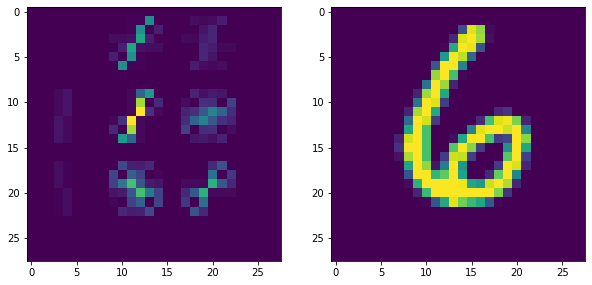

In [160]:
plt.figure(figsize = (10, 10))

# Visualizing the HoG descriptor
plt.subplot(121)
plt.imshow(hog_images[8911])

# Visualing the original image
plt.subplot(122)
plt.imshow(data[8911])

In [157]:
labels = np.asarray(labels)

In [158]:
# splitting the data into training and testing set
X_train, X_test, y_train, y_test = train_test_split(hog_features,labels,test_size=0.2)
print('Training data and target sizes: \n{}, {}'.format(X_train.shape,y_train.shape))
print('Test data and target sizes: \n{}, {}'.format(X_test.shape,y_test.shape))

Training data and target sizes: 
(48000, 128), (48000,)
Test data and target sizes: 
(12000, 128), (12000,)


In [170]:
# scaling the training set
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_train)

In [171]:
# Applying K-Nearest Neighbors Classifier to train the prepared data and predict the test set
knn = KNeighborsClassifier(n_neighbors=3, algorithm='brute')
knn.fit(X_scaled, y_train)
predicted = knn.predict(X_test)

In [164]:
class_names = list(Counter(y_test).keys())
class_names = [str(x) for x in class_names]

In [172]:
# Computing the accuracy of KNN classifier
test_accuracy = knn.score(scaler.transform(X_test), y_test)
print("Accuracy Score of KNN classifier:", test_accuracy)

Accuracy Score of KNN classifier: 0.94375


# Session 2

## Ans 8: CNN based Classifer using Transfer Learning 

In [14]:
import keras
from keras.datasets import mnist
from tensorflow.keras.utils import to_categorical
from keras.applications.vgg19 import VGG19
from keras import backend as K
from keras.utils.vis_utilsls import plot_model
from keras.models import Sequential
from keras.layers import Dense, Flatten, Conv2D, MaxPooling2D
from keras.callbacks import ModelCheckpoint, EarlyStopping
from sklearn.model_selection import train_test_split

In [43]:
# Loading the mnist dataset
(X_train, y_train), (X_test, y_test) = mnist.load_data()

In [44]:
X_train = X_train[:1000, :, :]
Y_train = y_train[:1000]
X_test = X_test[:400, :, :]
Y_test = y_test[:400]

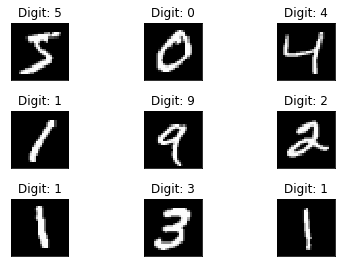

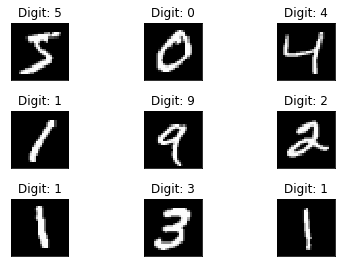

In [45]:
# Visualizing the data
fig = plt.figure()
for i in range(9):
    plt.subplot(3,3,i+1)
    plt.tight_layout()
    plt.imshow(X_train[i], cmap='gray', interpolation='none')
    plt.title("Digit: {}".format(y_train[i]))
    plt.xticks([])
    plt.yticks([])
fig

In [46]:
IMG_SIZE = 32
def resize(img_array):
    tmp = np.empty((img_array.shape[0], IMG_SIZE, IMG_SIZE))

    for i in range(len(img_array)):
        img = img_array[i].reshape(28, 28).astype('uint8')
        img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
        img = img.astype('float32')/255
        tmp[i] = img
        
    return tmp

In [47]:
X_train = resize(X_train)
X_test = resize(X_test)
X_train = np.stack((X_train,)*3, axis=-1)
X_test = np.stack((X_test,)*3, axis=-1)
print('X_train shape:', X_train.shape)
print('X_test shape:', X_test.shape)

X_train shape: (1000, 32, 32, 3)
X_test shape: (400, 32, 32, 3)


In [53]:
# set number of categories
num_category = 10

# convert class vectors to binary class matrices
Y_train = keras.utils.np_utils.to_categorical(Y_train, num_category)
Y_test = keras.utils.np_utils.to_categorical(Y_test, num_category)

In [54]:
# building the CNN model
vgg19 = VGG19(weights = 'imagenet', 
              include_top = False,
              input_shape=(IMG_SIZE, IMG_SIZE, 3)
              )

model = Sequential()
model.add(vgg19)
model.add(Flatten())
model.add(Dense(10, activation='softmax'))
model.compile(loss='categorical_crossentropy', 
              optimizer='sgd', 
              metrics=['accuracy'])

model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg19 (Functional)          (None, 1, 1, 512)         20024384  
                                                                 
 flatten_3 (Flatten)         (None, 512)               0         
                                                                 
 dense_3 (Dense)             (None, 10)                5130      
                                                                 
Total params: 20,029,514
Trainable params: 20,029,514
Non-trainable params: 0
_________________________________________________________________


In [55]:
print(X_train.shape)
print(X_test.shape)
print(Y_train.shape)
print(Y_test.shape)

(1000, 32, 32, 3)
(400, 32, 32, 3)
(1000, 10)
(400, 10)


In [56]:
es = EarlyStopping(monitor='val_accuracy', verbose=1, patience=5)
mc = ModelCheckpoint(filepath='mnist-vgg19.h5', verbose=1, monitor='val_accuracy')
cb = [es, mc]

In [59]:
# fitting the model
model.fit(X_train, Y_train, epochs=10, batch_size=128, validation_data=(X_test, Y_test), callbacks=cb)

Epoch 1/10
8/8 [==============================] - ETA: 0s - loss: 2.1425 - accuracy: 0.2840
Epoch 1: saving model to mnist-vgg19.h5
8/8 [==============================] - 47s 6s/step - loss: 2.1425 - accuracy: 0.2840 - val_loss: 2.2556 - val_accuracy: 0.2825
Epoch 2/10
8/8 [==============================] - ETA: 0s - loss: 1.8833 - accuracy: 0.4290
Epoch 2: saving model to mnist-vgg19.h5
8/8 [==============================] - 51s 7s/step - loss: 1.8833 - accuracy: 0.4290 - val_loss: 1.6291 - val_accuracy: 0.4500
Epoch 3/10
8/8 [==============================] - ETA: 0s - loss: 1.7594 - accuracy: 0.4370
Epoch 3: saving model to mnist-vgg19.h5
8/8 [==============================] - 54s 7s/step - loss: 1.7594 - accuracy: 0.4370 - val_loss: 1.5836 - val_accuracy: 0.4800
Epoch 4/10
8/8 [==============================] - ETA: 0s - loss: 1.3742 - accuracy: 0.5280
Epoch 4: saving model to mnist-vgg19.h5
8/8 [==============================] - 57s 7s/step - loss: 1.3742 - accuracy: 0.5280 - val_

In [61]:
# evaluating the accuracy of the model
model.evaluate(X_test, Y_test)

13/13 [==============================] - 1s 111ms/step - loss: 0.1039 - accuracy: 0.9675


[0.1038966104388237, 0.9674999713897705]

**The Accuracy of pretrained model of CNN (0.9675) is more than accuracy of KNN model (0.9437) on Hog Descriptors.**
**Generally, efficiently trained CNN models are to robust for classification as we in this case.**

## Ans 4: Optic Flow and LK feature tracking

In [4]:
# Applying Optic flow
cap = cv2.VideoCapture("videoplayback_Trim.mp4")
ret, first_frame = cap.read()
prev_gray = cv2.cvtColor(first_frame, cv2.COLOR_BGR2GRAY)
mask = np.zeros_like(first_frame)
mask[..., 1] = 255
  
while(cap.isOpened()):
    ret, frame = cap.read()
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    flow = cv2.calcOpticalFlowFarneback(prev_gray, gray, 
                                       None,
                                       0.5, 3, 15, 3, 5, 1.2, 0)
    magnitude, angle = cv2.cartToPolar(flow[..., 0], flow[..., 1])
    mask[..., 0] = angle * 180 / np.pi / 2
    mask[..., 2] = cv2.normalize(magnitude, None, 0, 255, cv2.NORM_MINMAX)
    rgb = cv2.cvtColor(mask, cv2.COLOR_HSV2BGR)
    prev_gray = gray
    break

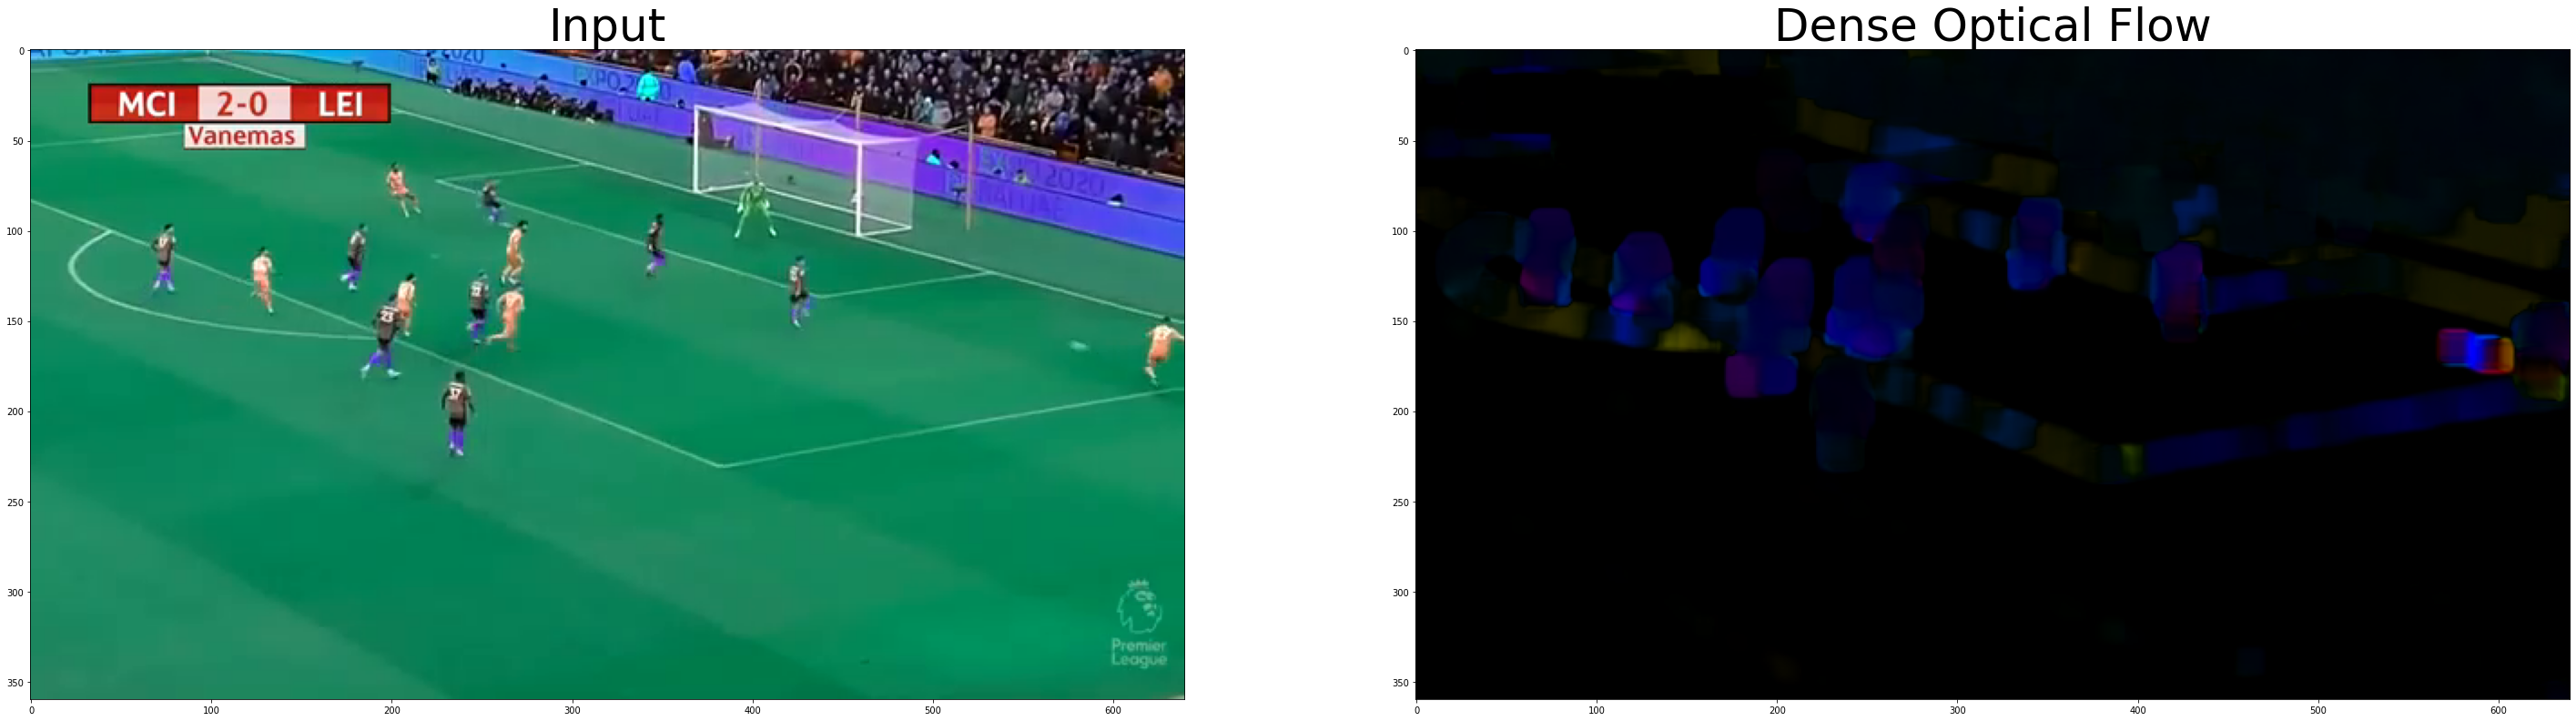

In [5]:
plt.figure(figsize = (50, 50))

plt.subplot(1,2,1)
plt.imshow(frame)
plt.title('Input', fontsize = 50)

plt.subplot(1,2,2)
plt.imshow(rgb)
plt.title('Dense Optical Flow', fontsize = 50)
plt.show()

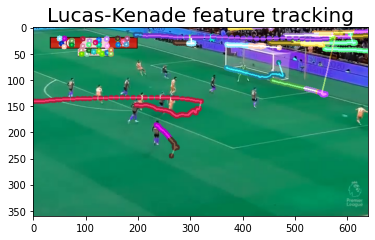

In [11]:
# Applying LK feature tracking
cap = cv2.VideoCapture("videoplayback_Trim.mp4")
  
# params for corner detection
feature_params = dict( maxCorners = 100,
                       qualityLevel = 0.3,
                       minDistance = 7,
                       blockSize = 7 )
  
# Parameters for lucas kanade optical flow
lk_params = dict( winSize = (15, 15),
                  maxLevel = 2,
                  criteria = (cv2.TERM_CRITERIA_EPS | cv2.TERM_CRITERIA_COUNT,
                              10, 0.03))
  
# Create some random colors
color = np.random.randint(0, 255, (100, 3))
  
# Take first frame and find corners in it
ret, old_frame = cap.read()
old_gray = cv2.cvtColor(old_frame, cv2.COLOR_BGR2GRAY)
p0 = cv2.goodFeaturesToTrack(old_gray, mask = None, **feature_params)
  
# Create a mask image for drawing purposes
mask = np.zeros_like(old_frame)
  
while True:
      
    ret, frame = cap.read()
    if not ret:
        break
    frame_gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
  
    # calculate optical flow
    p1, st, err = cv2.calcOpticalFlowPyrLK(old_gray,
                                           frame_gray,
                                           p0, None,
                                           **lk_params)
  
    # Select good points
    good_new = p1[st == 1]
    good_old = p0[st == 1]
  
    # draw the tracks
    for i, (new, old) in enumerate(zip(good_new, 
                                       good_old)):
        a, b = new.ravel().astype(int)
        c, d = old.ravel().astype(int)
        
        mask = cv2.line(mask, (a, b), (c, d), color[i].tolist(), 2)
        frame = cv2.circle(old_frame, (a, b), 5, color[i].tolist(), -1)
          
    img = cv2.add(frame, mask)
    # Updating Previous frame and points 
    old_gray = frame_gray.copy()
    p0 = good_new.reshape(-1, 1, 2)
    
plt.imshow(img)
plt.title('Lucas-Kenade feature tracking', fontsize = 20)
plt.show()  